# Working with Superphot+

Superphot+ was designed to rapidly fit photometric SN-like light curves to an empirical model for subsequent classification or analysis.
This tutorial briefly covers how to import light curves directly from ALeRCE or ANTARES, apply pre-processing for improved quality, and run various sampling methods to fit the light curves.

## Data Importing and Preprocessing

Superphot+ is built on SNAPI (https://github.com/kdesoto-astro/snapi), which provides functionality for easy importing and pre-processing of photometric data from various alert brokers. Here, we use SNAPI to import a ZTF light curve from ALeRCE.

In [1]:
# All imports/filepaths for this section
!pip list
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from snapi.query_agents import ALeRCEQueryAgent, TNSQueryAgent
from snapi import Formatter, Photometry, Transient

test_sn = "2023lkw"
p = Path(os.getcwd()).parents[1]
SAVE_DIR = os.path.join(p, "data", "tutorial")
print(SAVE_DIR)


Package                          Version                       Editable project location
-------------------------------- ----------------------------- -------------------------------------------------------------------
absl-py                          2.3.0
alabaster                        1.0.0
alembic                          1.16.1
alerce                           1.4.0
annoy                            1.17.3
antares-client                   1.8.0
appnope                          0.1.4
arviz                            0.21.0
astroid                          3.3.10
astropy                          6.1.7
astropy_healpix                  1.1.2
astropy-iers-data                0.2025.6.2.0.38.23
asttokens                        3.0.0
asv                              0.6.4
asv_runner                       0.2.1
attrs                            25.3.0
babel                            2.17.0
backports-datetime-fromisoformat 2.0.3
beautifulsoup4                   4.13.4
bleach             

In [2]:
alerce_agent = ALeRCEQueryAgent()
tns_agent = TNSQueryAgent(db_path=SAVE_DIR)
transient = Transient(iid=test_sn)
qr_tns, success = tns_agent.query_transient(transient, local=True) # we dont want spectra
for result in qr_tns:
    transient.ingest_query_info(result.to_dict())
print(transient.internal_names)
qr_alerce, success = alerce_agent.query_transient(transient)
for result in qr_alerce:
    transient.ingest_query_info(result.to_dict())

{'Gaia23cpz', 'PS23ezy', 'ATLAS23nab', 'ZTF23aaphnyz'}


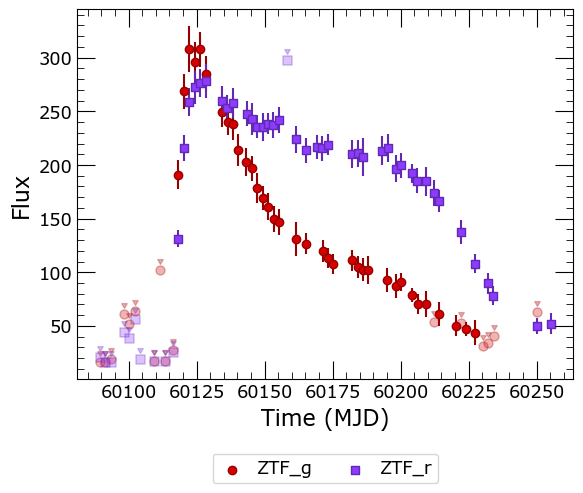

In [3]:
# plot imported LC
photometry = transient.photometry
formatter = Formatter()
fig, ax = plt.subplots()

photometry.plot(ax, mags=False)
formatter.add_legend(ax)
formatter.make_plot_pretty(ax)
plt.show()

Here, the nondetections are marked as semi-transparent upper-limits, with the detections shown opaque wih uncertainty margins. Superphot+ currently only works with detections.

Let's phase/normalize the light curve and correct for extinction. Note that, for the Superphot+ samplers, the photometry MUST be phased and normalized to be fit correctly.

/Users/charisgraham/Desktop/Summer2025/superphotplus/snapi/src/snapi/photometry/photometry.py:172: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peaks = self.detections.groupby("filter", group_keys=False).apply(


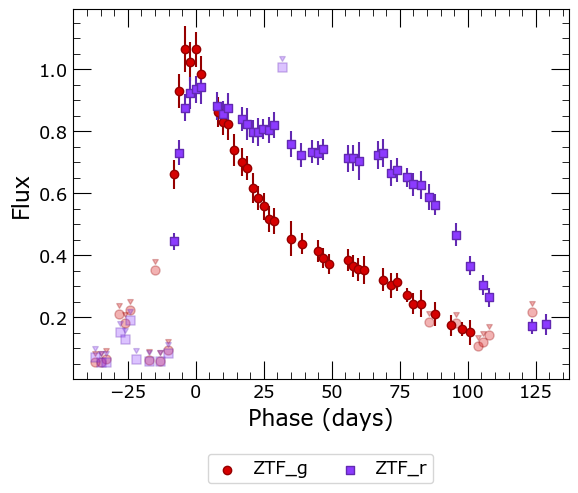

In [4]:
photometry.phase(inplace=True)
photometry.normalize(inplace=True)
photometry.correct_extinction(coordinates=transient.coordinates, inplace=True)
transient.photometry = photometry

fig, ax = plt.subplots()

photometry.plot(ax, mags=False)
formatter.add_legend(ax)
formatter.make_plot_pretty(ax)
plt.show()


Now let's save this file for later use:

In [5]:
transient.save(
    os.path.join(SAVE_DIR, test_sn)
)

For our numpyro samplers, we need to pad all bands to have the same number of points. To do this, we create a padded variant of our transient photometry:

/opt/miniconda3/envs/superphot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


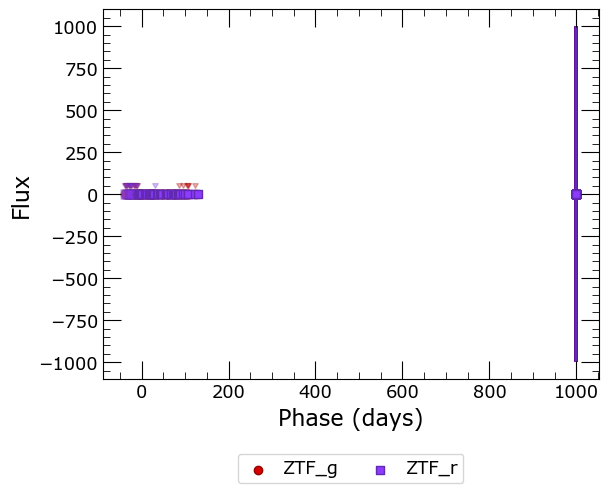

In [6]:
transient = Transient.load(
    os.path.join(SAVE_DIR, test_sn),
)

n_pad = int(2**np.ceil(np.log2(len(transient.photometry.detections))))

padded_lcs = set()
fill = {'phase': 1000., 'flux': 0.1, 'flux_unc': 1000., 'zpt': 23.90, 'non_detections': False}

padded_lcs = []
for lc in transient.photometry.light_curves:
    padded_lc=lc.pad(fill, n_pad - len(lc.detections))
    padded_lcs.append(padded_lc)

padded_photometry = Photometry.from_light_curves(padded_lcs)
transient.photometry = padded_photometry
transient.save(
    os.path.join(SAVE_DIR, test_sn+"_padded")
)
formatter = Formatter()
fig, ax = plt.subplots()
padded_photometry.plot(ax, mags=False)
formatter.add_legend(ax)
formatter.make_plot_pretty(ax)
plt.show()


## Fitting Light Curves

In [7]:
# All imports for this section
import os
from pathlib import Path

import matplotlib.pyplot as plt
from snapi import Transient, Formatter, SamplerResult

from superphot_plus.samplers import DynestySampler, NUTSSampler, SVISampler
from superphot_plus.priors import generate_priors, SuperphotPrior

p = Path(os.getcwd()).parents[1]
SAVE_DIR = os.path.join(p, "data", "tutorial")

test_sn = "2023lkw"

There are a few sampling techniques implemented for rapid fitting of light curves:
* Nested sampling (`dynesty`) constrains the posterior space with nested ellipsoids of increasing density.
* Advanced HMC with the NUTS sampler (using `numpyro`) uses Hamiltonian Monte Carlo sampling but without U-turns to increase sampling efficiency.
* Stochastic variational inference (SVI; also using `numpyro`) approximates the marginal distributions for each fit as Gaussians, which sacrifices precision for much faster runtime. Recommended for realtime applications.

Let's use each to fit our test light curve:

In [10]:
fn_to_fit = os.path.join(SAVE_DIR, test_sn)
transient = Transient.load(fn_to_fit)
photometry = transient.photometry
priors = generate_priors(["ZTF_r","ZTF_g"])

In [11]:
%%time

sampler = DynestySampler(
    priors=priors,
    random_state=42,
    verbose=True,
    nlive=100,
)
sampler.fit_photometry(photometry)
sampler.result.save(
    os.path.join(SAVE_DIR, test_sn+f"_{sampler.name}")
)
print("Nested sampling")
print(sampler.result.fit_parameters.head())

/opt/miniconda3/envs/superphot/lib/python3.10/site-packages/dynesty/dynamicsampler.py:530: RuntimeWarning: All the initial likelihood values are the same. You likely have a plateau in the likelihood. Nested sampling may not be the best sampler in this case.
  warnings.warn(


['A_ZTF_r' 'beta_ZTF_r' 'gamma_ZTF_r' 't_0_ZTF_r' 'tau_rise_ZTF_r'
 'tau_fall_ZTF_r' 'extra_sigma_ZTF_r' 'A_ZTF_g' 'beta_ZTF_g' 'gamma_ZTF_g'
 't_0_ZTF_g' 'tau_rise_ZTF_g' 'tau_fall_ZTF_g' 'extra_sigma_ZTF_g'] ['A', 'beta', 'gamma', 't_0', 'tau_rise', 'tau_fall', 'extra_sigma']


3987it [00:26, 152.93it/s, +100 | bound: 246 | nc: 1 | ncall: 128479 | eff(%):  3.184 | loglstar:   -inf < 148.398 <    inf | logz: 109.325 +/-    nan | dlogz:  0.004 >  0.400]


Nested sampling
    A_ZTF_r  beta_ZTF_r  gamma_ZTF_r  t_0_ZTF_r  tau_rise_ZTF_r  \
0  0.941340    0.003769    93.939630  -8.063065        1.610248   
1  0.945161    0.003848    93.750241  -8.025188        1.800998   
2  0.884936    0.002852    89.943200  -8.004628        0.966257   
3  0.927641    0.003442    93.722996  -7.915225        1.618651   
4  0.909228    0.003290    91.148168  -8.071562        1.297950   

   tau_fall_ZTF_r  extra_sigma_ZTF_r   A_ZTF_g  beta_ZTF_g  gamma_ZTF_g  \
0       31.603953           0.003321  1.105106    0.012851     7.461897   
1       29.512224           0.001464  1.096089    0.013275     8.349212   
2       31.441235           0.015126  1.095325    0.013022    21.262566   
3       27.489273           0.001856  1.074139    0.009122     6.088931   
4       29.998973           0.006111  1.045360    0.011568    12.758979   

   t_0_ZTF_g  tau_rise_ZTF_g  tau_fall_ZTF_g  extra_sigma_ZTF_g  
0  -8.579482        0.919277       55.141812           0.002213 

In [12]:
%%time

# use padded photometry
padded_fn = os.path.join(SAVE_DIR, test_sn + "_padded")
pad_transient = Transient.load(padded_fn)
pad_photometry = pad_transient.photometry

sampler = NUTSSampler(
    priors=priors,
    num_chains=1,
    num_warmup=5000,
    num_samples=1000,
    random_state=42
)
sampler.fit_photometry(pad_photometry)
sampler.result.save(
    os.path.join(SAVE_DIR, test_sn+f"_{sampler.name}")
)
print("NUTS")
print(sampler.result.fit_parameters.head())

['A_ZTF_r' 'beta_ZTF_r' 'gamma_ZTF_r' 't_0_ZTF_r' 'tau_rise_ZTF_r'
 'tau_fall_ZTF_r' 'extra_sigma_ZTF_r' 'A_ZTF_g' 'beta_ZTF_g' 'gamma_ZTF_g'
 't_0_ZTF_g' 'tau_rise_ZTF_g' 'tau_fall_ZTF_g' 'extra_sigma_ZTF_g'] ['A', 'beta', 'gamma', 't_0', 'tau_rise', 'tau_fall', 'extra_sigma']


sample: 100%|██████████| 6000/6000 [00:27<00:00, 219.01it/s, 73 steps of size 1.93e-02. acc. prob=0.97]  


NUTS
    A_ZTF_r  beta_ZTF_r  gamma_ZTF_r  t_0_ZTF_r  tau_rise_ZTF_r  \
0  0.898871    0.003094    89.445419  -8.139860        1.294625   
1  0.894862    0.003142    89.824936  -8.206831        1.226001   
2  0.934084    0.003590    93.434067  -7.856703        1.345354   
3  0.937955    0.003636    94.163467  -7.762991        1.278102   
4  0.926299    0.003733    96.015488  -8.163525        1.620381   

   tau_fall_ZTF_r  extra_sigma_ZTF_r   A_ZTF_g  beta_ZTF_g  gamma_ZTF_g  \
0       35.589096           0.002336  1.045614    0.012469     8.715165   
1       33.137005           0.002472  1.077264    0.008645     8.271728   
2       29.350805           0.003916  1.028762    0.006595     8.121267   
3       27.152578           0.003499  0.948156   -0.001536     7.813797   
4       27.160673           0.004002  1.028475    0.010731    10.575709   

   t_0_ZTF_g  tau_rise_ZTF_g  tau_fall_ZTF_g  extra_sigma_ZTF_g  
0  -8.898348        1.110777       59.766296           0.005223  
1  -8.965

In [11]:
%%time

# use padded photometry: only necessary if you're planning on running repeatedly on different events
# if one-time fit, feel free to not use padding
padded_fn = os.path.join(SAVE_DIR, test_sn + "_padded")
pad_transient = Transient.load(padded_fn)
pad_photometry = pad_transient.photometry

sampler = SVISampler(
    priors=priors,
    num_iter=10_000,
    random_state=42,
)
sampler.fit_photometry(pad_photometry)
sampler.result.save(
    os.path.join(SAVE_DIR, test_sn+f"_{sampler.name}")
)
print("SVI")
print(sampler.result.fit_parameters.head())

['A_ZTF_r' 'beta_ZTF_r' 'gamma_ZTF_r' 't_0_ZTF_r' 'tau_rise_ZTF_r'
 'tau_fall_ZTF_r' 'extra_sigma_ZTF_r' 'A_ZTF_g' 'beta_ZTF_g' 'gamma_ZTF_g'
 't_0_ZTF_g' 'tau_rise_ZTF_g' 'tau_fall_ZTF_g' 'extra_sigma_ZTF_g'] ['A', 'beta', 'gamma', 't_0', 'tau_rise', 'tau_fall', 'extra_sigma']


/Users/charisgraham/Desktop/Summer2025/superphotplus/superphot-plus/src/superphot_plus/samplers/numpyro_sampler.py:36: UserWarning: Found plate statements in guide but not model: {'base_params'}
  return elbo.loss(


SVI
    A_ZTF_r  beta_ZTF_r  gamma_ZTF_r  t_0_ZTF_r  tau_rise_ZTF_r  \
0  0.983262    0.003824    59.277706  -9.824593        4.300210   
1  0.982490    0.004329    63.339687  -9.714280        2.485976   
2  0.991552    0.005049    65.562698 -10.258060        3.677208   
3  0.978884    0.003398    60.463337 -11.863361        5.445509   
4  0.977440    0.002823    60.359829  -8.082873        2.945588   

   tau_fall_ZTF_r  extra_sigma_ZTF_r   A_ZTF_g  beta_ZTF_g  gamma_ZTF_g  \
0       82.624512           0.095281  1.040321    0.008088    15.110422   
1       92.500679           0.113491  0.998078    0.004799    13.964373   
2       90.855080           0.119476  1.016017    0.007999    13.711315   
3      101.428947           0.125239  1.008298    0.007627    12.903291   
4       67.065689           0.137183  1.015704    0.007317     9.909479   

   t_0_ZTF_g  tau_rise_ZTF_g  tau_fall_ZTF_g  extra_sigma_ZTF_g  
0 -10.244479        2.342710       62.136021           0.053346  
1 -10.1436

In [13]:
# NEW!!! Hierarchical SVI - uses better priorss
priors = SuperphotPrior.load(os.path.join(SAVE_DIR, "global_priors_hier_svi"))
padded_fn = os.path.join(SAVE_DIR, test_sn + "_padded")
pad_transient = Transient.load(padded_fn)
pad_photometry = pad_transient.photometry

sampler = SVISampler(
    priors=priors,
    num_iter=10_000,
    random_state=42,
)
sampler.fit_photometry(pad_photometry)
sampler.result.save(
    os.path.join(SAVE_DIR, test_sn+f"_{sampler.name}_hierarchical")
)
print("SVI")
print(sampler.result.fit_parameters.head())

['A_ZTF_r' 'beta_ZTF_r' 'gamma_ZTF_r' 't_0_ZTF_r' 'tau_rise_ZTF_r'
 'tau_fall_ZTF_r' 'extra_sigma_ZTF_r' 'A_ZTF_g' 'beta_ZTF_g' 'gamma_ZTF_g'
 't_0_ZTF_g' 'tau_rise_ZTF_g' 'tau_fall_ZTF_g' 'extra_sigma_ZTF_g'] ['A', 'beta', 'gamma', 't_0', 'tau_rise', 'tau_fall', 'extra_sigma']


/Users/charisgraham/Desktop/Summer2025/superphotplus/superphot-plus/src/superphot_plus/samplers/numpyro_sampler.py:36: UserWarning: Found plate statements in guide but not model: {'base_params'}
  return elbo.loss(


SVI
    A_ZTF_r  beta_ZTF_r  gamma_ZTF_r  t_0_ZTF_r  tau_rise_ZTF_r  \
0  0.926159    0.003583    90.916603  -7.885880        1.279590   
1  0.925896    0.003649    91.327751  -7.874299        1.028235   
2  0.928970    0.003742    91.542465  -7.931389        1.202112   
3  0.924668    0.003528    91.039268  -8.099926        1.406035   
4  0.924176    0.003454    91.028648  -7.703021        1.100259   

   tau_fall_ZTF_r  extra_sigma_ZTF_r   A_ZTF_g  beta_ZTF_g  gamma_ZTF_g  \
0       34.432541           0.012641  1.039805    0.011383    20.134060   
1       35.783951           0.017233  1.013008    0.009820    18.569523   
2       35.565613           0.018876  1.024438    0.011340    18.224491   
3       36.925999           0.020519  1.019529    0.011163    17.123898   
4       32.068275           0.024113  1.024239    0.011016    13.062392   

   t_0_ZTF_g  tau_rise_ZTF_g  tau_fall_ZTF_g  extra_sigma_ZTF_g  
0  -8.782706        1.331176       58.285000           0.019944  
1  -8.7523

Now, let's plot each fit to compare results!

['A_ZTF_r' 'beta_ZTF_r' 'gamma_ZTF_r' 't_0_ZTF_r' 'tau_rise_ZTF_r'
 'tau_fall_ZTF_r' 'extra_sigma_ZTF_r' 'A_ZTF_g' 'beta_ZTF_g' 'gamma_ZTF_g'
 't_0_ZTF_g' 'tau_rise_ZTF_g' 'tau_fall_ZTF_g' 'extra_sigma_ZTF_g'] ['A', 'beta', 'gamma', 't_0', 'tau_rise', 'tau_fall', 'extra_sigma']
['A_ZTF_r' 'beta_ZTF_r' 'gamma_ZTF_r' 't_0_ZTF_r' 'tau_rise_ZTF_r'
 'tau_fall_ZTF_r' 'extra_sigma_ZTF_r' 'A_ZTF_g' 'beta_ZTF_g' 'gamma_ZTF_g'
 't_0_ZTF_g' 'tau_rise_ZTF_g' 'tau_fall_ZTF_g' 'extra_sigma_ZTF_g'] ['A', 'beta', 'gamma', 't_0', 'tau_rise', 'tau_fall', 'extra_sigma']
['A_ZTF_r' 'beta_ZTF_r' 'gamma_ZTF_r' 't_0_ZTF_r' 'tau_rise_ZTF_r'
 'tau_fall_ZTF_r' 'extra_sigma_ZTF_r' 'A_ZTF_g' 'beta_ZTF_g' 'gamma_ZTF_g'
 't_0_ZTF_g' 'tau_rise_ZTF_g' 'tau_fall_ZTF_g' 'extra_sigma_ZTF_g'] ['A', 'beta', 'gamma', 't_0', 'tau_rise', 'tau_fall', 'extra_sigma']


/opt/miniconda3/envs/superphot/lib/python3.10/site-packages/dynesty/dynamicsampler.py:530: RuntimeWarning: All the initial likelihood values are the same. You likely have a plateau in the likelihood. Nested sampling may not be the best sampler in this case.
  warnings.warn(
/Users/charisgraham/Desktop/Summer2025/superphotplus/superphot-plus/src/superphot_plus/samplers/numpyro_sampler.py:431: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self._mcmc = MCMC(


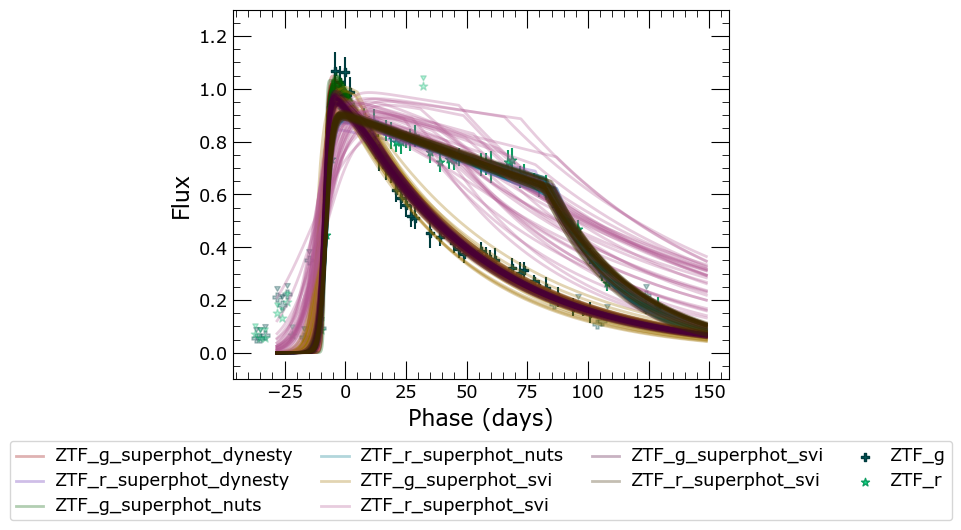

In [14]:
fn_to_fit = os.path.join(SAVE_DIR, test_sn)
transient = Transient.load(fn_to_fit)
photometry = transient.photometry
priors = generate_priors(["ZTF_r","ZTF_g"])

fig, ax = plt.subplots()
formatter = Formatter()
dsampler = DynestySampler(priors=priors)
nsampler = NUTSSampler(priors=priors)
ssampler = SVISampler(priors=priors)
for sampler in [dsampler, nsampler, ssampler]:
    sr = SamplerResult.load(os.path.join(SAVE_DIR, test_sn+f"_{sampler.name}"))
    sampler.load_result(sr)
    ax = sampler.plot_fit(
        ax, formatter,
        photometry,
    )
sr = SamplerResult.load(os.path.join(SAVE_DIR, test_sn+f"_{ssampler.name}_hierarchical"))
ssampler.load_result(sr)
ax = ssampler.plot_fit(
    ax, formatter,
    photometry,
)

photometry.plot(ax, formatter, mags=False)
ax.set_ylim((-0.1, 1.3))
formatter.add_legend(ax)
formatter.make_plot_pretty(ax)
plt.show()


All three fits look decent, differing most in the r-band fit. Note how the hierarchical SVI fit does better than the one from default priors for the same number of training iterations. Let's examine the plateau durations for each sampler:

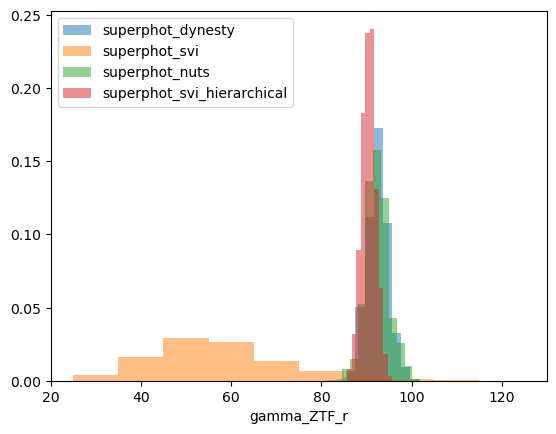

In [15]:
for sampler_name in ["superphot_dynesty", "superphot_svi", "superphot_nuts", "superphot_svi_hierarchical"]:
    sr = SamplerResult.load(os.path.join(SAVE_DIR, test_sn+f"_{sampler_name}"))
    fit_params = sr.fit_parameters
    # param naming convention: {paramname}_{filter}
    plt.hist(fit_params["gamma_ZTF_r"], alpha=0.5, label=sampler_name, density=True)

plt.xlabel("gamma_ZTF_r")
plt.legend()
plt.show()

## Classification

Superphot+ uses the resulting fit parameters as input features for a LightGBM classifier. We can call the model's evaluate() function to return probabilities of the object being each of 5 major supernova types. But first, we convert our auxiliary-band and log-Gaussian parameters back to Gaussian relative values, for better normalization before classification.

In [17]:
import os
import numpy as np
from superphot_plus.priors import generate_priors
from superphot_plus.supernova_class import SupernovaClass
from superphot_plus.model import SuperphotLightGBM
from snapi import SamplerResult
from pathlib import Path

p = Path(os.getcwd()).parents[1]
SAVE_DIR = os.path.join(p, "data", "tutorial")
test_sn = "2023lkw"


In [18]:

model_fn = os.path.join(SAVE_DIR, "model_superphot_full.pt")
# if from the full train workflow notebook, use below:
#model_fn = os.path.join(SAVE_DIR, "models/model_superphot_svi_LightGBM_None_False_25_None_10_100_42_0.pt")
full_model = SuperphotLightGBM.load(model_fn)

priors = generate_priors(["ZTF_r","ZTF_g"])
sr = SamplerResult.load(os.path.join(SAVE_DIR, test_sn+f"_superphot_nuts"))

# convert fit parameters back to uncorrelated Gaussian draws
uncorr_fits = priors.reverse_transform(sr.fit_parameters)

# fix index for groupby() operations within model.evaluate()
uncorr_fits.index = [test_sn,] * len(uncorr_fits)

# exclude A_ZTF_r and t_0_ZTF_r - that's how the model was initially trained!
uncorr_fits.drop(
    columns=['A_ZTF_r', 't_0_ZTF_r'],
    inplace=True
)
print(uncorr_fits.median(axis=0))

# use full-phase classifier
probs_avg = full_model.evaluate(uncorr_fits)
probs_avg.columns = np.sort(['SN Ia', 'SN Ibc', 'SN II', 'SN IIn', 'SLSN-I'])
# if modeled was trained with SN Ibn class, use below:
#probs_avg.columns = np.sort(['SN Ia', 'SN Ibc', 'SN II', 'SN IIn', 'SLSN-I', 'SN Ibn'])
# get predicted SN class and output probability of that classification
pred_class = probs_avg.idxmax(axis=1).iloc[0]
print(probs_avg, pred_class)

beta_ZTF_r           0.003503
gamma_ZTF_r          1.964809
tau_rise_ZTF_r       0.129645
tau_fall_ZTF_r       1.492414
extra_sigma_ZTF_r   -2.399152
A_ZTF_g              0.045560
beta_ZTF_g           0.001144
gamma_ZTF_g         -1.089647
t_0_ZTF_g           -0.705891
tau_rise_ZTF_g      -0.158672
tau_fall_ZTF_g       0.257765
extra_sigma_ZTF_g    0.030955
dtype: float32
           SLSN-I     SN II    SN IIn     SN Ia    SN Ibc
2023lkw  0.027884  0.955903  0.005224  0.007718  0.003271 SN II


Looking at the TNS page, we see that 2023lkw is indeed a SN II. For an example on how to use the built-in SuperphotTrainer class, see the full train workflow notebook. To include more SN classes, please train a new model.